# Tripulación - Cruceros

## Importación de librerías a utilizar

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import pearsonr
from mlxtend.evaluate import bias_variance_decomp

## Lectura del archivo con pandas

In [2]:
df = pd.read_csv('Cruceros.csv')

## Mostrar columnas

In [3]:
df.head()

,Ship_name,Cruise_line,Age,Tonnage,passengers,length,cabins,passenger_density,crew
0,Journey,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
1,Quest,Azamara,6,30.277,6.94,5.94,3.55,42.64,3.55
2,Celebration,Carnival,26,47.262,14.86,7.22,7.43,31.80,6.70
3,Conquest,Carnival,11,110.000,29.74,9.53,14.88,36.99,19.10
4,Destiny,Carnival,17,101.353,26.42,8.92,13.21,38.36,10.00


In [4]:
#Creamos congruencia en la escritura
df.columns = df.columns.str.lower()

In [5]:
df.columns

Index(['ship_name', 'cruise_line', 'age', 'tonnage', 'passengers', 'length',
       'cabins', 'passenger_density', 'crew'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ship_name          158 non-null    object 
 1   cruise_line        158 non-null    object 
 2   age                158 non-null    int64  
 3   tonnage            158 non-null    float64
 4   passengers         158 non-null    float64
 5   length             158 non-null    float64
 6   cabins             158 non-null    float64
 7   passenger_density  158 non-null    float64
 8   crew               158 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 11.2+ KB


* Tenemos 158 entidades en el dataset
* Tenemos un total de 9 columnas, de las cuales 2 son categoricas nominales y 7 numericas continuas, incluida nuestra variable objetivo
* No tenemos valores nulos en nuestro dataset.

In [7]:
categorical_columns = ['ship_name', 'cruise_line']
for col in categorical_columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    print()

ship_name
['Journey' 'Quest' 'Celebration' 'Conquest' 'Destiny']
138

cruise_line
['Azamara' 'Carnival' 'Celebrity' 'Costa' 'Crystal']
20



In [8]:
df.cruise_line.value_counts()

Royal_Caribbean      23
Carnival             22
Princess             17
Holland_American     14
Norwegian            13
Costa                11
Celebrity            10
MSC                   8
Star                  6
P&O                   6
Regent_Seven_Seas     5
Silversea             4
Oceania               3
Seabourn              3
Windstar              3
Cunard                3
Disney                2
Crystal               2
Azamara               2
Orient                1
Name: cruise_line, dtype: int64

* Adicional, tenemos 138 nombres de barcos únicos, es decir, algunos comparten el nombre

Vamos a quitar el simbolo &

In [9]:
df.cruise_line = df.cruise_line.replace('&','n')

In [10]:
df.drop_duplicates().shape

(158, 9)

* Al intentar eliminar duplicados y obtener el mismo numero de filas, vemos que aunque compartan nombre son barcos diferentes.

## Estadisticas básicas

In [11]:
numerical_columns = ['age', 'tonnage', 'passengers', 'length',
       'cabins', 'passenger_density', 'crew']

In [12]:
df[numerical_columns].agg(["min", "max",'mean','std', "median", "skew"]).T

,min,max,mean,std,median,skew
age,4.000,48.00,15.689873,7.615691,14.000,1.234593
tonnage,2.329,220.00,71.284671,37.229540,71.899,0.498268
passengers,0.660,54.00,18.457405,9.677095,19.500,0.409181
length,2.790,11.82,8.130633,1.793474,8.555,-0.785259
cabins,0.330,27.00,8.830000,4.471417,9.570,0.270291
passenger_density,17.700,71.43,39.900949,8.639217,39.085,0.940975
crew,0.590,21.00,7.794177,3.503487,8.150,0.194787


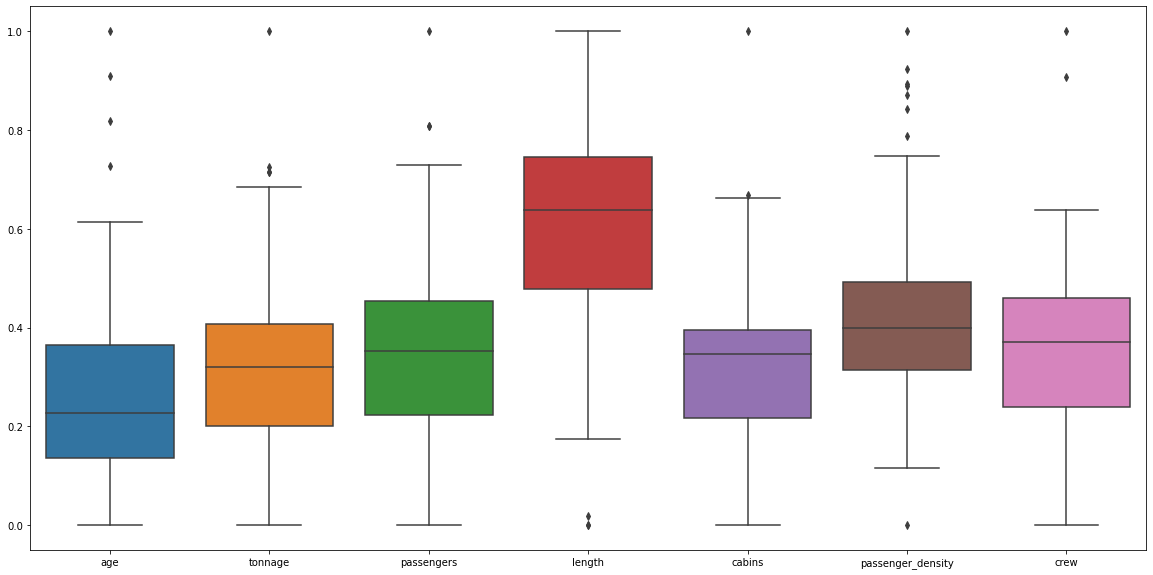

In [13]:
dt_features = MinMaxScaler().fit_transform(df[numerical_columns])
plt.figure(figsize=(20,10))
sns.boxplot(data=dt_features)
plt.xticks(range(7),labels=numerical_columns);

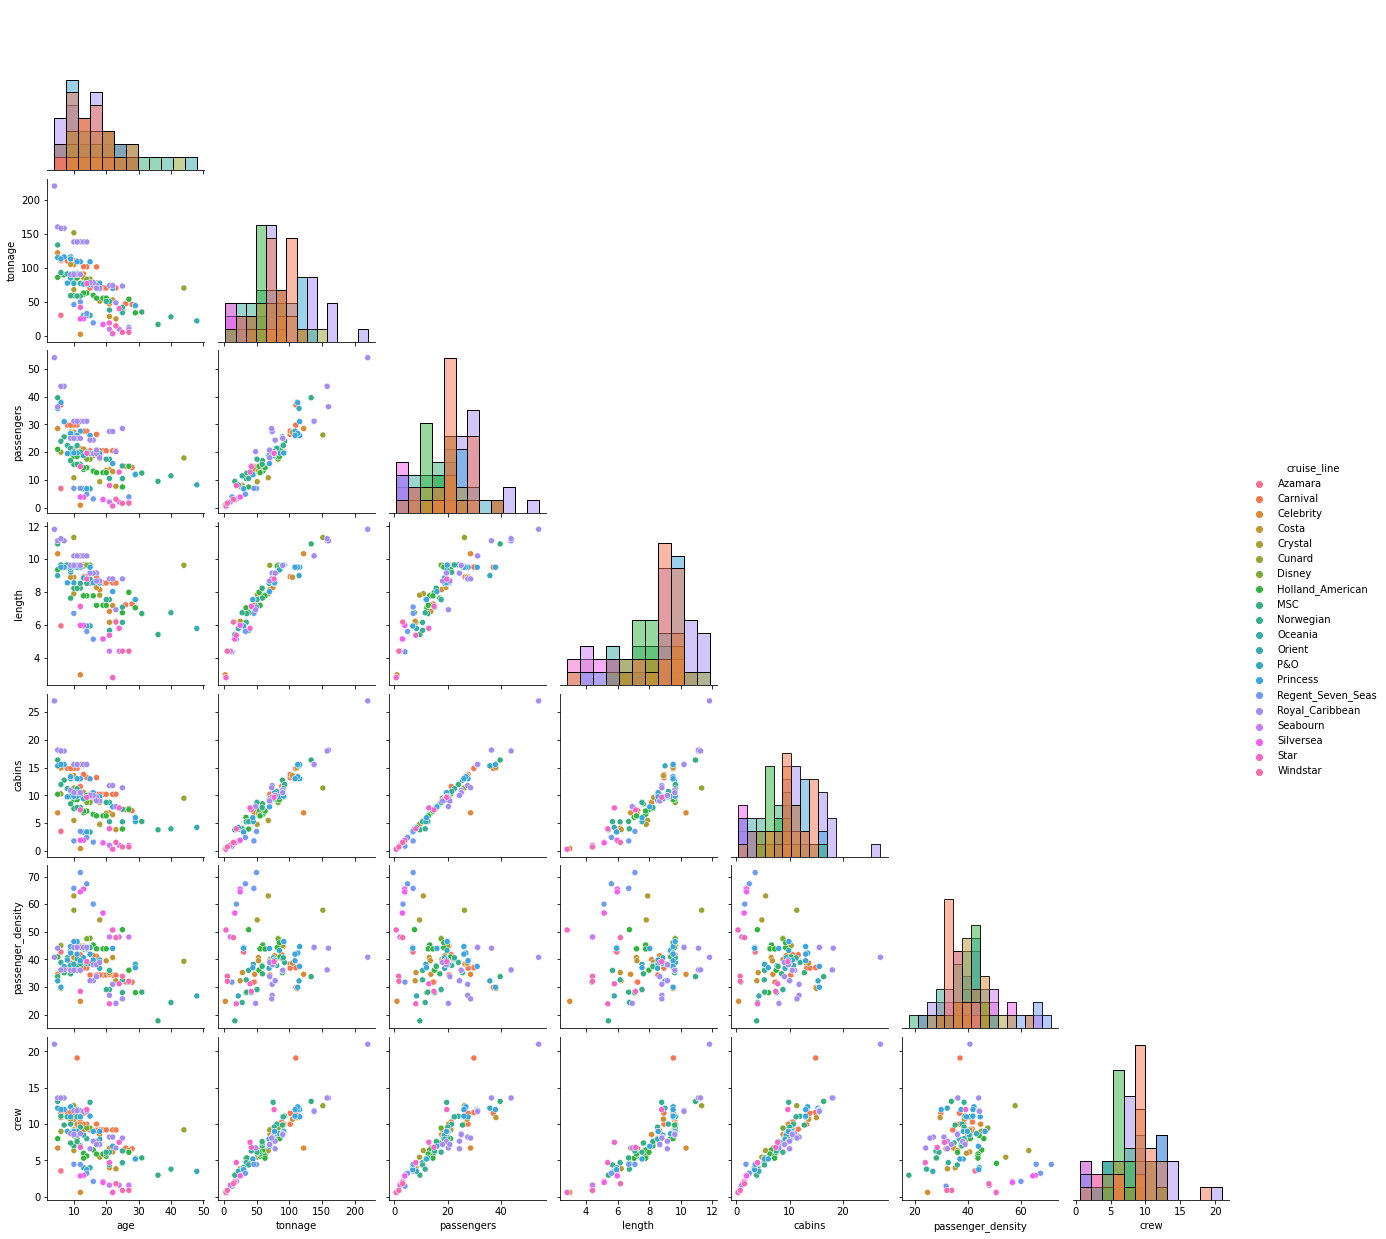

In [14]:
sns.pairplot(df, hue = 'cruise_line', corner = True, diag_kind = 'hist')

## Selección de Columnas

Text(0.5, 1.0, 'Correlations between predictors')

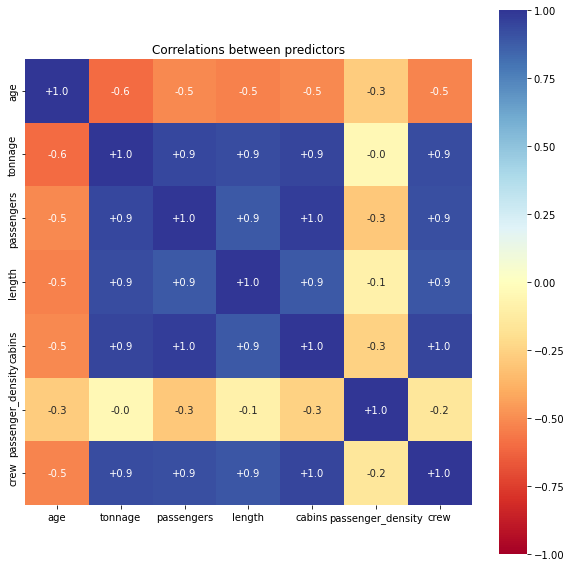

In [15]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap="RdYlBu", 
    annot=True, square=True,
    vmin=-1, vmax=1, fmt="+.1f")
plt.title("Correlations between predictors")

Podemos ver que tenemos una alta correlación entre las variables: *tonnage, passengers, length y cabins,* y nuestra variable objetivo, pero a la vez estas estan correlacionadas entre ellas, lo cual nos traerá problemas de **multicolinealiadad**. Así mismo vemos que la variable *paseger density* tiene una baja correlación con la variable objetivo

De las 4 variables que se mecionan, dejaremos la que tena la correlación más alta, eliminaremos la variable *paseger density* por tener una baja correlación y la varíable **ship_name* por ser más una identificaión del barco. por lo tanto nuestras variables seran:

In [16]:
features = ['cruise_line', 'age', 'cabins', 'crew']

## One-hot enconding

In [17]:
df_oh = pd.get_dummies(df[features],columns=['cruise_line'],drop_first=True)
df_oh.head()

,age,cabins,crew,cruise_line_Carnival,cruise_line_Celebrity,cruise_line_Costa,cruise_line_Crystal,cruise_line_Cunard,cruise_line_Disney,cruise_line_Holland_American,...,cruise_line_Oceania,cruise_line_Orient,cruise_line_P&O,cruise_line_Princess,cruise_line_Regent_Seven_Seas,cruise_line_Royal_Caribbean,cruise_line_Seabourn,cruise_line_Silversea,cruise_line_Star,cruise_line_Windstar
0,6,3.55,3.55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,3.55,3.55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,26,7.43,6.70,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,11,14.88,19.10,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,17,13.21,10.00,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Creación de conjuntos de entrenamieto y prueba

In [18]:
X = df_oh.drop(['crew'], axis=1)
y = df_oh.crew

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print(len(df_oh))
print(len(X_train) + len(X_test))
print(len(X_train), len(X_test), len(y_train), len(y_test))

158
158
94 64 94 64


## Creación de modelo de aprendizaje automático

Creamos una maquina vectrial de soporte con un kernel lineal

In [19]:
model = SVR(kernel='linear')
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test,y_pred)
score = model.score(X_test,y_test)
print('mse',mse)
print('score',score)

mse 0.6710959086212614
score 0.9468835609990082


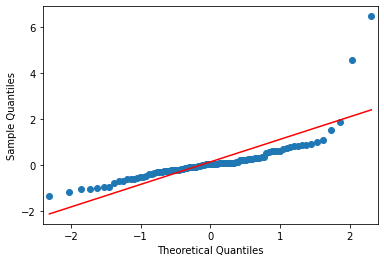

In [20]:
sm.qqplot(y_train-model.predict(X_train), line="s");

## Calculo de coeficiente de pearson

In [21]:
print('pearson train',pearsonr(y_train,model.predict(X_train))[0])
print('pearson test',pearsonr(y_test,model.predict(X_test))[0])

pearson train 0.9586148055323954
pearson test 0.9732999010339507


## Descripción de hiperparametros

La regresión por soporte vectorial cuenta con varios hipeparámetros, como el kernel a utilizar, el grado en caso de usar un kernel polinomial, un parámetro C de regularización y un parámetro epsilon para la penalización en la función de perdida.

Haremos una busqueda aleatoria de los mejores parámetro C y epsilón.

In [22]:
model_svr = SVR(kernel='linear')

parametros = {
    'C' : np.arange(0,10,0.001),
    'epsilon' : np.arange(0,10,0.001)
}

rand_est = RandomizedSearchCV(model_svr, parametros ,n_jobs=12, n_iter=5000, cv=5,scoring='neg_root_mean_squared_error').fit(X_train,y_train)

print(rand_est.best_estimator_)
print(rand_est.best_params_)
print(rand_est.score(X_train,y_train))
print(rand_est.score(X_test,y_test))

SVR(C=1.056, epsilon=0.807, kernel='linear')
{'epsilon': 0.807, 'C': 1.056}
-1.017869219472967
-0.8509797104184952


/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 25000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-packages/sklearn/svm/_base.py", line 251, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "/home/jaimeh94/anaconda3/envs/platzi-env/lib/python3.9/site-pack

In [23]:
print('pearson train',pearsonr(y_train,rand_est.predict(X_train))[0])
print('pearson test',pearsonr(y_test,rand_est.predict(X_test))[0])

pearson train 0.9576586602182527
pearson test 0.971808652722236


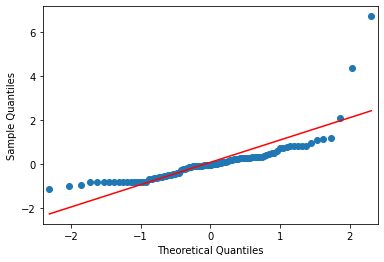

In [24]:
sm.qqplot(y_train-rand_est.predict(X_train), line="s");

## Reguralización

La regularización se refiere al método para ajustar el modelo de predicción en orden de reducir la varianza sin incrementar el sesgo. En el modelo descrito el **C** es el parámetro de reguralización, L2 en este caso.

## Bias Variance trade-off

Para evaluar el sesgo y varianza usamos la libreria *mlxtend* y su función *bias_variance_decomp*

In [25]:
bias_var = []
for i in np.arange(0.001,2,0.001):
    model = SVR(C=i,epsilon=0.275).fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # score.append(model.score(X_test,y_test))
    # mse.append(mean_squared_error(y_test,y_pred))
    avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
            model, X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy(), 
            loss='0-1_loss',
            random_seed=123)
    bias_var.append([i,avg_expected_loss, avg_bias, avg_var])
bias_var = pd.DataFrame(bias_var,columns=['C','avg_expected_loss', 'avg_bias', 'avg_var'])
bias_var.head()

,C,avg_expected_loss,avg_bias,avg_var
0,0.001,0.976797,0.96875,0.514609
1,0.002,0.976562,0.96875,0.507812
2,0.003,0.976406,0.96875,0.506719
3,0.004,0.976328,0.96875,0.505781
4,0.005,0.976250,0.96875,0.503828


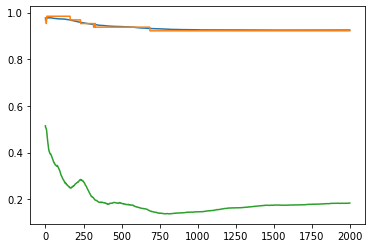

In [26]:
plt.plot(bias_var[['avg_expected_loss', 'avg_bias', 'avg_var']])

El modelo sufre de sesgo (bias) al ser principalmente lineal